# **Conditional Variational AutoEncoder**

### Importing Libaray

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
import matplotlib.pyplot as plt

### Hyper Parameters

In [ ]:
batch_size = 64
test_batch_size = 1000
seed = 1
lr = 0.001
no_cuda = False
eps = 20
z_dim = 2
drop_prob = 0.25

use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

print("Device:", end=" ")
print(device)

Device: cuda


### Data Loader
Prepare date loader for training and test  
Then, check data with pyplot

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


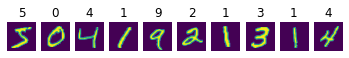

In [ ]:
fig = plt.figure()

for i in range(10):
  train_x = train_data.data[i]
  train_y = train_data.targets[i]

  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(train_x)
  ax.set_title(str(train_y.item()))
  ax.axis("off")

plt.show()

### Encoder and Decoder

In [ ]:
# Gaussian MLP as encoder
class gaussian_MLP_encoder(nn.Module):
  def __init__(self, h1=500, h2=500, n_output=2, drop_prob=0.5):
    super(gaussian_MLP_encoder, self).__init__()
    self.fc1 = nn.Linear(794, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc_mean = nn.Linear(h2, n_output)
    self.fc_stddev = nn.Linear(h2, n_output)
    self.drop_prob = drop_prob

    nn.init.kaiming_uniform_(self.fc1.weight)
    nn.init.kaiming_uniform_(self.fc2.weight)
    nn.init.kaiming_uniform_(self.fc_mean.weight)
    nn.init.kaiming_uniform_(self.fc_stddev.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)
    nn.init.zeros_(self.fc_mean.bias)
    nn.init.zeros_(self.fc_stddev.bias)

  def reparametrize(self, mu, logvar):
    std = (logvar.exp_()).mul(0.5)
    eps = torch.FloatTensor(std.size()).normal_()
    eps = Variable(eps).cuda()
    return eps.mul(std).add_(mu)

  def forward(self, x, y):
    x = x.view(-1, 784)
    input = torch.cat([x, y], 1)
    x = F.dropout(F.elu(self.fc1(input)), p=self.drop_prob)
    x = F.dropout(torch.tanh(self.fc2(x)), p=self.drop_prob)
    mean = self.fc_mean(x)     # mean
    stddev = self.fc_stddev(x) # log(var)

    rp = self.reparametrize(mean, stddev)

    return mean, stddev, rp

In [ ]:
# Bernoulli MLP as decoder
class bernoulli_MLP_decoder(nn.Module):
  def __init__(self, h1=500, h2=500, n_input=2, drop_prob=0.5):
    super(bernoulli_MLP_decoder, self).__init__()
    self.fc1 = nn.Linear(n_input+10, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, 784)
    self.drop_prob = drop_prob

    nn.init.kaiming_uniform_(self.fc1.weight)
    nn.init.kaiming_uniform_(self.fc2.weight)
    nn.init.kaiming_uniform_(self.fc3.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)
    nn.init.zeros_(self.fc3.bias)
    

  def forward(self, x, y):
    input = torch.cat([x, y], 1)
    x = F.dropout(torch.tanh(self.fc1(input)), p=self.drop_prob)
    x = F.dropout(F.elu(self.fc2(x)), p=self.drop_prob)
    x = torch.sigmoid(self.fc3(x))
    return x.view(-1, 1, 28, 28)

In [ ]:
encoder = gaussian_MLP_encoder(n_output=z_dim, drop_prob=drop_prob).cuda()
decoder = bernoulli_MLP_decoder(n_input=z_dim, drop_prob=drop_prob).cuda()
parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=lr)

# Loss Function
def loss_function(recon_x, x, mu, logvar):
  reconstruction_function = nn.BCELoss()
  BCE = reconstruction_function(recon_x, x)
  KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
  KLD = torch.sum(KLD_element).mul_(-0.5) / (batch_size * 784)
  return BCE + KLD

### Training

============= Epoch 1 =============
100: loss = -16.420475
200: loss = -16.405729
300: loss = -17.438044
400: loss = -21.445173
500: loss = -20.749903
600: loss = -20.301777
700: loss = -22.854549
800: loss = -23.876230
900: loss = -23.165079
============= Epoch 2 =============
100: loss = -24.502640
200: loss = -23.715103
300: loss = -25.447655
400: loss = -25.321386
500: loss = -26.301561
600: loss = -25.333952
700: loss = -25.887552
800: loss = -26.673950
900: loss = -26.084721
============= Epoch 3 =============
100: loss = -25.886850
200: loss = -25.871336
300: loss = -27.114840
400: loss = -27.224665
500: loss = -25.075907
600: loss = -26.264641
700: loss = -26.345037
800: loss = -28.182499
900: loss = -25.931358
============= Epoch 4 =============
100: loss = -25.592573
200: loss = -27.058336
300: loss = -27.737751
400: loss = -24.963995
500: loss = -29.506287
600: loss = -28.006239
700: loss = -27.153358
800: loss = -26.896748
900: loss = -28.588333
============= Epoch 5 ======

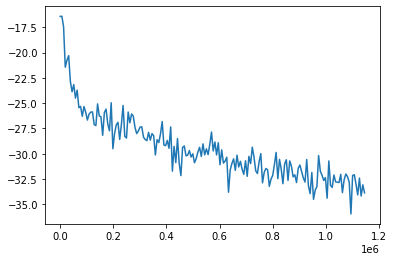

In [ ]:
encoder.train()
decoder.train()

cnt, batches, losses = 0, [], []
min_loss = 999999
for ep in range(eps):
  ep_min_loss_flag = False
  print("============= Epoch %d =============" % (ep+1))
  for batch_idx, (image, label) in enumerate(train_loader):
    optimizer.zero_grad()

    vec = torch.zeros((label.shape[0], 10))
    vec[range(label.shape[0]), label] = 1

    image = Variable(image).cuda()
    vec = Variable(vec).cuda()
    
    mu, log_var, reparam = encoder(image, vec)
    output = decoder(reparam, vec)
    
    loss = loss_function(output, image, mu, log_var)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 99:
      print("%d: loss = %f" % ((batch_idx+1), loss))
      losses.append(loss.cpu().data.numpy())
      batches.append(cnt)
      cnt = cnt + batch_size*100

plt.plot(batches, losses)
plt.show()

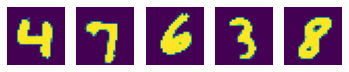

In [ ]:
out_img = torch.squeeze(output.cpu().data)
n_out = 5

fig = plt.figure()

for i in range(n_out):
  ax = fig.add_subplot(1, n_out, i+1)
  ax.imshow(out_img[i].numpy())
  ax.axis("off")

plt.show()

### Test

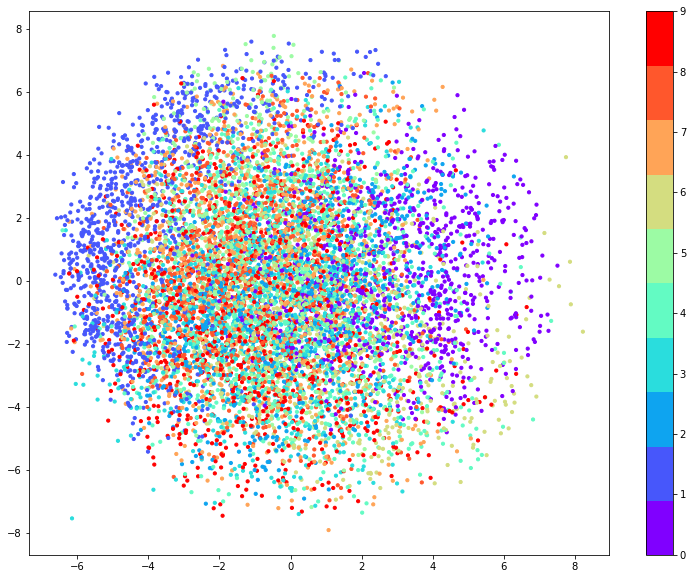

In [ ]:
# Test
encoder.eval()
decoder.eval()

outputs, x, y, z = [], [], [], []

for batch_idx, (image, label) in enumerate(test_loader):

  vec = torch.zeros((label.shape[0], 10))
  vec[range(label.shape[0]), label] = 1

  image = Variable(image).cuda()
  vec = Variable(vec).cuda()
  
  mu, log_var, reparam = encoder(image, vec)
  output = decoder(reparam, vec)
  
  for i in range(test_batch_size):
    if i % 1 == 0:
      x.append(reparam[i][0].cpu().data.numpy())
      y.append(reparam[i][1].cpu().data.numpy())
      z.append(label[i].cpu().data.numpy())
  outputs.append(output)

plt.figure(figsize=(13,10))
plt.scatter(x, y, c=z, s=10, cmap=plt.cm.get_cmap('rainbow', 10))
plt.colorbar()

### Check Reconstruction

torch.Size([1000, 28, 28])


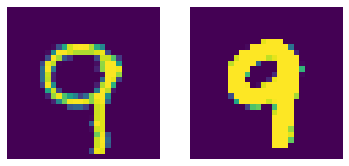

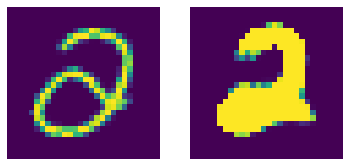

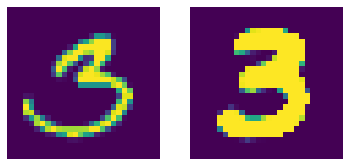

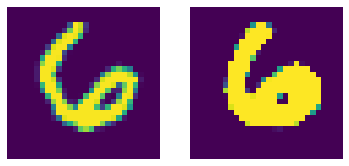

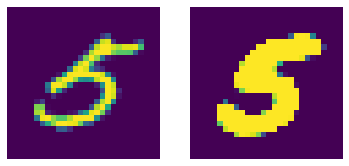

In [ ]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(torch.squeeze(image[i].cpu()).data.numpy())
  ax.axis("off")
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(out_img[i].numpy())
  ax.axis("off")
  plt.show()

### Make new handwritting by decoder

#### |z|=2

Making handwrittings.. [------------------->] 100%

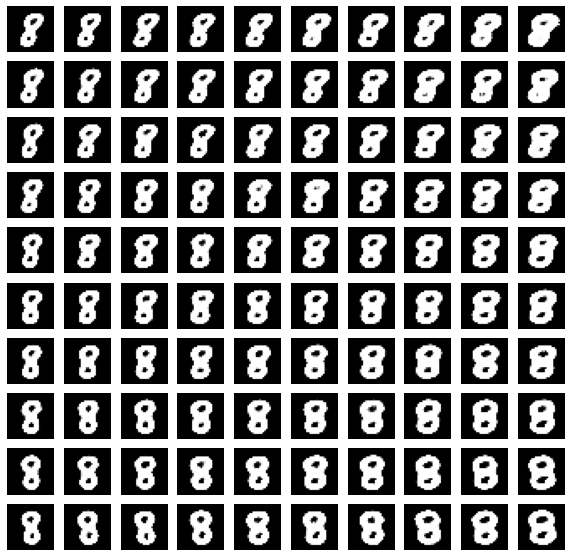

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def progressBar(value, endvalue, bar_length=20, title="Percent:"):
  percent = float(value) / endvalue
  arrow = '-' * int(round(percent * bar_length)-1) + '>'
  spaces = ' ' * (bar_length - len(arrow))

  print("\r"+title+" [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))), end="")

num_slider = widgets.IntSlider(description="Number: ", min=0, max=9)
#slider_lim = widgets.FloatSlider(description="Sampling Limit: ", min=0.5, max=5, step=0.5)
button = widgets.Button(description="Make!")
hbox = widgets.HBox([num_slider, button])
display(hbox)

def make_handwritting(b):
  if z_dim != 2:
    print("Code only for |z|=2")
    return
  clear_output(wait=True)
  display(hbox)
  fig = plt.figure(figsize=(10,10))

  c = torch.zeros(1,10).cuda()
  c[0, num_slider.value] = 1
  
  for j in range(10):
    for i in range(10):
      z = [[i*0.5-2.25, 2.25-0.5*j]]
      z = torch.FloatTensor(z).cuda()
      output = decoder(z, c)
      ax = fig.add_subplot(10, 10, i+1+10*j)
      ax.imshow(torch.squeeze(output.cpu()).data.numpy(), cmap="gray")
      ax.axis("off")
      progressBar(i+10*j+1, 100, title="Making handwrittings..")
   
button.on_click(make_handwritting)

#### |z| >= 2

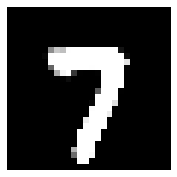

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

num_slider = widgets.IntSlider(description="Number: ", min=0, max=9)
sliders = []
for i in range(z_dim):
  slider = widgets.FloatSlider(min=-3.0, max=3.0, step=0.1, description="z["+str(i)+"]")
  sliders.append(slider)
button = widgets.Button(description="Make!")
hbox = widgets.HBox([num_slider, button])
vbox = widgets.VBox(sliders)
display(hbox, vbox)

def make_handwritting(b):
  clear_output(wait=True)
  fig = plt.figure(figsize=(3,3))
  display(hbox, vbox)

  c = torch.zeros(1,10)
  c[0, num_slider.value] = 1
  z = torch.zeros(1, z_dim)
  for i in range(z_dim):
    z[0, i] = sliders[i].value
  
  z = torch.FloatTensor(z).cuda()
  c = torch.FloatTensor(c).cuda()
  output = decoder(z, c)
  plt.imshow(torch.squeeze(output.cpu()).data.numpy(), cmap="gray")
  plt.axis("off")
   
button.on_click(make_handwritting)

#### make 0~9 with same z

Button(description='Make!', style=ButtonStyle())

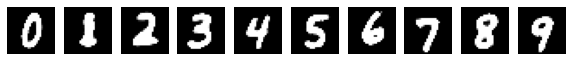

In [ ]:
sliders = []
for i in range(z_dim):
  slider = widgets.FloatSlider(min=-3.0, max=3.0, step=0.1, description="z["+str(i)+"]")
  sliders.append(slider)
button = widgets.Button(description="Make!")
vbox = widgets.VBox(sliders)
display(vbox, button)

def make_digits(b):
  clear_output(wait=True)
  fig = plt.figure(figsize=(10,10))
  display(vbox, button)

  z = torch.zeros(1, z_dim)
  for i in range(z_dim):
    z[0, i] = sliders[i].value
  z = torch.FloatTensor(z).cuda()

  for i in range(10):
    c = torch.zeros(1,10)
    c[0, i] = 1
    c = torch.FloatTensor(c).cuda()
    output = decoder(z, c)
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(torch.squeeze(output.cpu()).data.numpy(), cmap="gray")
    ax.axis("off")
   
button.on_click(make_digits)